In [ ]:
# ========================= IMPORTS =========================
import tensorflow as tf  # For F1 score metric (optional)
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import numpy as np
import pickle
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
import os


# ========================= DOWNLOAD AND ORGANIZE DATASET =========================

# Define paths
DATA_PATH = '/content/satellite_data'  # Path to save the dataset in Drive

# Download and extract the dataset
!curl -SL https://storage.googleapis.com/wandb_datasets/dw_train_86K_val_10K.zip > dw_data.zip
!unzip dw_data.zip
!rm dw_data.zip

# Move the extracted dataset to Google Drive
!mkdir -p {DATA_PATH}
!mv droughtwatch_data/train {DATA_PATH}/train
!mv droughtwatch_data/val {DATA_PATH}/val
!rm -r droughtwatch_data  # Clean up

# Verify dataset location and structure
import os
print(f"Train files: {len(os.listdir(DATA_PATH + '/train'))}")
print(f"Validation files: {len(os.listdir(DATA_PATH + '/val'))}")


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2050M  100 2050M    0     0  18.5M      0  0:01:50  0:01:50 --:--:-- 17.9M
Archive:  dw_data.zip
   creating: droughtwatch_data/
   creating: droughtwatch_data/val/
  inflating: droughtwatch_data/val/part-r-00090  
  inflating: droughtwatch_data/val/part-r-00061  
  inflating: droughtwatch_data/val/part-r-00052  
  inflating: droughtwatch_data/val/part-r-00043  
  inflating: droughtwatch_data/val/part-r-00040  
  inflating: droughtwatch_data/val/part-r-00042  
  inflating: droughtwatch_data/val/part-r-00067  
  inflating: droughtwatch_data/val/part-r-00026  
  inflating: droughtwatch_data/val/part-r-00046  
  inflating: droughtwatch_data/val/part-r-00023  
  inflating: droughtwatch_data/val/part-r-00083  
  inflating: droughtwatch_data/val/part-r-00011  
  inflating: droughtwatch_data/val/part-r-00058  
  inflating: droughtwat

In [ ]:
import os
import tensorflow as tf
import numpy as np

def combine_rgb(b2, b3, b4):
    """Combines three satellite bands (B2, B3, B4) into an RGB image."""
    blue = tf.io.decode_raw(b2, tf.uint8)
    green = tf.io.decode_raw(b3, tf.uint8)
    red = tf.io.decode_raw(b4, tf.uint8)

    img_size = int(tf.sqrt(tf.cast(tf.shape(blue)[0], tf.float32)))
    blue = tf.reshape(blue, (img_size, img_size))
    green = tf.reshape(green, (img_size, img_size))
    red = tf.reshape(red, (img_size, img_size))

    return tf.stack([red, green, blue], axis=-1)

def parse_tfrecord(record):
    """Parses TFRecord and extracts image and label."""
    feature_description = {
        "B2": tf.io.FixedLenFeature([], tf.string),
        "B3": tf.io.FixedLenFeature([], tf.string),
        "B4": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.int64),
    }
    parsed = tf.io.parse_single_example(record, feature_description)
    return combine_rgb(parsed["B2"], parsed["B3"], parsed["B4"]), parsed["label"]

def augment_images(dataset, num_augmentations=2):
    """Augments images to increase dataset size."""
    def augment(image, label):
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        image = tf.image.random_brightness(image, max_delta=0.1)
        return image, label

    augmented_dataset = dataset.flat_map(lambda x, y: tf.data.Dataset.from_tensors((x, y)).concatenate(
        tf.data.Dataset.from_tensors((augment(x, y)))
    ))
    return augmented_dataset.take(num_augmentations * len(list(dataset)))

def create_balanced_datasets(raw_dataset):
    """Creates balanced training and validation datasets based on original class distribution."""
    # Separate original classes
    class_0 = raw_dataset.filter(lambda x, y: y == 0)
    class_1 = raw_dataset.filter(lambda x, y: y == 1)
    class_2 = raw_dataset.filter(lambda x, y: y == 2)
    class_3 = raw_dataset.filter(lambda x, y: y == 3)
    class_4 = raw_dataset.filter(lambda x, y: y == 4)

    # Training data preparation (drought: classes 0-1, non-drought: classes 2-4)
    train_drought_0 = class_0.shuffle(50000, seed=42).take(13000)
    train_drought_1 = class_1.shuffle(50000, seed=42).take(12000)

    train_nondrought_2 = class_2.shuffle(50000, seed=42).take(10000)
    train_nondrought_3 = class_3.shuffle(50000, seed=42).take(8043)
    train_nondrought_3_aug = augment_images(train_nondrought_3, num_augmentations=2).take(15000)

    # Validation data preparation (2500 samples from each original class)
    val_drought_0 = class_0.shuffle(50000, seed=43).take(2500)
    val_drought_1 = class_1.shuffle(50000, seed=43).take(2500)
    val_nondrought_2 = class_2.shuffle(50000, seed=43).take(2500)
    val_nondrought_3 = class_3.shuffle(50000, seed=43).take(2500)

    # Combine and assign binary labels (0 for drought, 1 for non-drought)
    new_train_drought = train_drought_0.concatenate(train_drought_1).map(lambda x, y: (x, tf.constant(0)))
    new_train_nondrought = train_nondrought_2.concatenate(train_nondrought_3_aug).map(lambda x, y: (x, tf.constant(1)))

    new_val_drought = val_drought_0.concatenate(val_drought_1).map(lambda x, y: (x, tf.constant(0)))
    new_val_nondrought = val_nondrought_2.concatenate(val_nondrought_3).map(lambda x, y: (x, tf.constant(1)))

    # Create final datasets
    train_dataset = new_train_drought.concatenate(new_train_nondrought).shuffle(50000, seed=42)
    val_dataset = new_val_drought.concatenate(new_val_nondrought).shuffle(50000, seed=42)

    return train_dataset, val_dataset

In [ ]:
def get_original_class_distribution(dataset):
    class_count = {0: 0, 1: 0, 2: 0, 3: 0}
    for _, label in dataset:
        class_count[int(label.numpy())] += 1
    return class_count

# Count the original class distribution
original_train_dist = get_original_class_distribution(raw_train_dataset)

print("Original Training dataset distribution:", original_train_dist)

def get_class_distribution(dataset):
    """Counts the number of instances per class."""
    class_count = {0: 0, 1: 0}
    for _, label in dataset:
        class_count[int(label.numpy())] += 1
    return class_count

# Load and prepare datasets
DATA_PATH = '/content/satellite_data'
train_tfrecords = tf.data.Dataset.list_files(os.path.join(DATA_PATH, "train/part*"))
raw_dataset = tf.data.TFRecordDataset(train_tfrecords).map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)

# Create balanced datasets
train_dataset, val_dataset = create_balanced_datasets(raw_dataset)

# Prepare final datasets for training
BATCH_SIZE = 32
final_train_dataset = train_dataset.cache().shuffle(50000, seed=42).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
final_val_dataset = val_dataset.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Print dataset distributions
print("Training dataset distribution:", get_class_distribution(train_dataset))
print("Validation dataset distribution:", get_class_distribution(val_dataset))

Training dataset distribution: {0: 25000, 1: 25000}
Validation dataset distribution: {0: 5000, 1: 5000}


In [ ]:

# Cell 2: Model Definition and Training
def build_efficientnet_model(input_shape=(65, 65, 3)):
    """Builds and compiles EfficientNetB0 model for drought classification."""
    inputs = tf.keras.layers.Input(shape=input_shape)

    efficientnet_base = tf.keras.applications.EfficientNetB0(
        include_top=False,
        weights=None,
        input_tensor=inputs,
    )

    x = tf.keras.layers.GlobalAveragePooling2D()(efficientnet_base.output)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Create and train model
model = build_efficientnet_model()
model.summary()

# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'drought_detection_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

# Train model
history = model.fit(
    final_train_dataset,
    validation_data=final_val_dataset,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)

# Save training history
import pickle
with open('training_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 65, 65, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 65, 65, 3)      │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 65, 65, 3)      │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 67, 67, 3)      │              0 │ normalization[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 33, 33, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 33, 33, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 33, 33, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 33, 33, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 33, 33, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 33, 33, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand         │ (None, 1, 1, 32)       │            288 │ block1a_se_reduce[0][… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 5,362,340 (20.46 MB)

 Trainable params: 5,320,317 (20.30 MB)

 Non-trainable params: 42,023 (164.16 KB)

Epoch 1/50
   1563/Unknown 218s 54ms/step - accuracy: 0.6279 - loss: 0.6511

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from inf to 0.66458, saving model to drought_detection_model.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 279s 93ms/step - accuracy: 0.6279 - loss: 0.6511 - val_accuracy: 0.6119 - val_loss: 0.6646
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6914 - loss: 0.5720
Epoch 2: val_loss improved from 0.66458 to 0.59702, saving model to drought_detection_model.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 76s 33ms/step - accuracy: 0.6914 - loss: 0.5720 - val_accuracy: 0.6954 - val_loss: 0.5970
Epoch 3/50
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7117 - loss: 0.5411
Epoch 3: val_loss improved from 0.59702 to 0.59207, saving model to drought_detection_model.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 32ms/step - accuracy: 0.7117 - loss: 0.5411 - val_accuracy: 0.6867 - val_loss: 0.5921
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7349 - loss: 0.5153
Epoch 4: val_loss improved from 0.59207 to 0.57113, saving model to drought_de

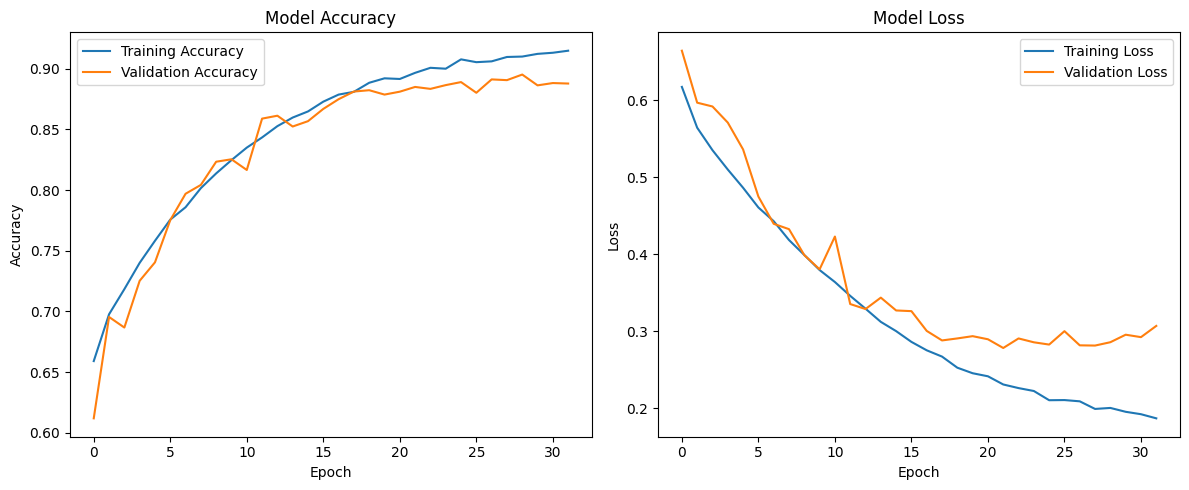

In [ ]:

# Cell 3: Model Evaluation and Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

def evaluate_model_performance(model, dataset, steps):
    """Evaluates model performance using various metrics."""
    # Get predictions and true labels
    y_pred_proba = []
    y_true = []

    print("Generating predictions...")
    for batch in dataset.take(steps):
        images, labels = batch
        batch_predictions = model.predict(images, verbose=0)
        y_pred_proba.extend(batch_predictions)
        y_true.extend(labels.numpy())

    # Convert to numpy arrays
    y_pred_proba = np.array(y_pred_proba)
    y_true = np.array(y_true)
    y_pred = (y_pred_proba >= 0.5).astype(int)

    # Calculate metrics
    conf_matrix = confusion_matrix(y_true, y_pred)
    class_report = classification_report(y_true, y_pred,
                                      target_names=['Drought', 'Non-Drought'])
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Print results
    print("\nClassification Report:")
    print(class_report)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Drought', 'Non-Drought'],
                yticklabels=['Drought', 'Non-Drought'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


Evaluating model performance...
Generating predictions...

Classification Report:
              precision    recall  f1-score   support

     Drought       0.88      0.90      0.89      4993
 Non-Drought       0.89      0.87      0.88      4991

    accuracy                           0.88      9984
   macro avg       0.89      0.88      0.88      9984
weighted avg       0.89      0.88      0.88      9984



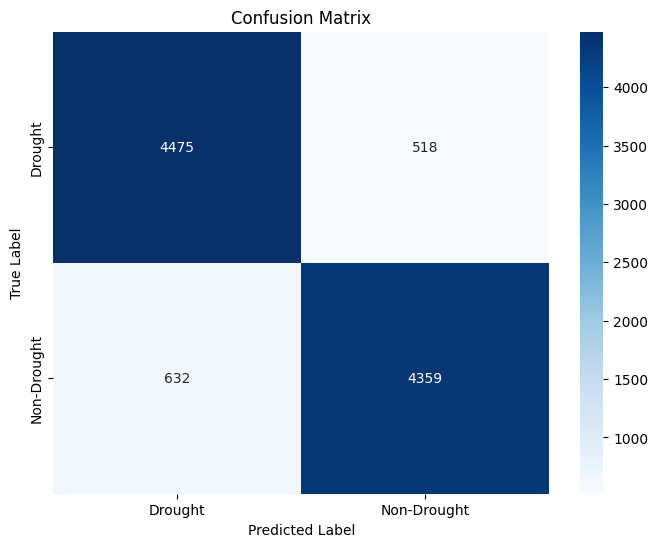

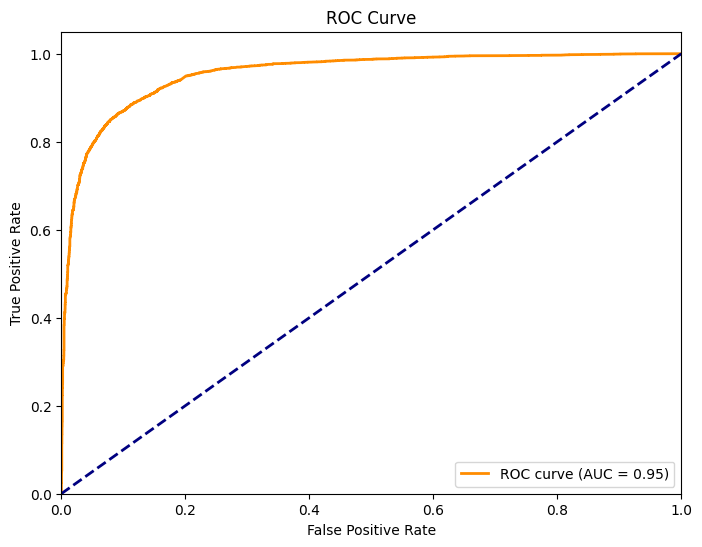

In [ ]:

# Evaluate model
print("\nEvaluating model performance...")
VAL_SAMPLES = 10000
validation_steps = VAL_SAMPLES // BATCH_SIZE
evaluate_model_performance(model, final_val_dataset, validation_steps)

Visualizing predictions on validation dataset:
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


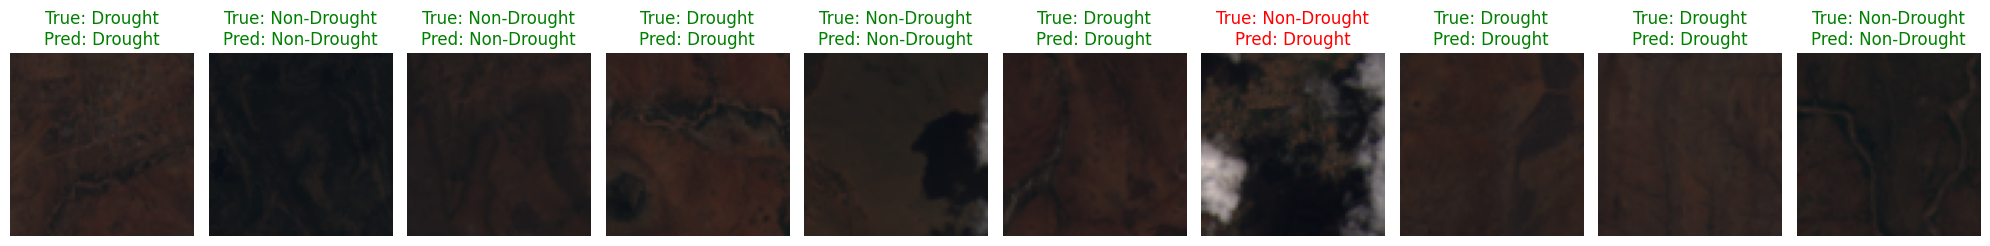

"\n# Replace 'path_to_your_image.jpg' with actual image path\nimage_path = 'path_to_your_image.jpg'\npredict_single_image(model, image_path)\n"

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, dataset, num_images=10):
    """
    Visualizes images with their true and predicted labels.

    Args:
        model: trained tensorflow model
        dataset: tf.data.Dataset containing images and labels
        num_images: number of images to visualize
    """
    # Get batch of images
    for images, labels in dataset.take(1):  # Take one batch
        # Make predictions
        predictions = model.predict(images)
        predictions = (predictions >= 0.5).astype(int)

        # Plot images
        plt.figure(figsize=(20, 4))
        for i in range(min(num_images, len(images))):
            plt.subplot(1, num_images, i + 1)

            # Convert image to display format if necessary
            img = images[i].numpy()
            if img.max() > 1:
                img = img / 255.0

            plt.imshow(img)

            # Set title with true and predicted labels
            true_label = "Drought" if labels[i] == 0 else "Non-Drought"
            pred_label = "Drought" if predictions[i] == 0 else "Non-Drought"
            color = 'green' if labels[i] == predictions[i] else 'red'

            plt.title(f'True: {true_label}\nPred: {pred_label}',
                     color=color)
            plt.axis('off')

        plt.tight_layout()
        plt.show()


# Example usage for validation dataset visualization:
print("Visualizing predictions on validation dataset:")
visualize_predictions(model, final_val_dataset.unbatch().batch(10))

# Example usage for single image prediction:
"""
# Replace 'path_to_your_image.jpg' with actual image path
image_path = 'path_to_your_image.jpg'
predict_single_image(model, image_path)
"""

Visualizing predictions on validation dataset:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


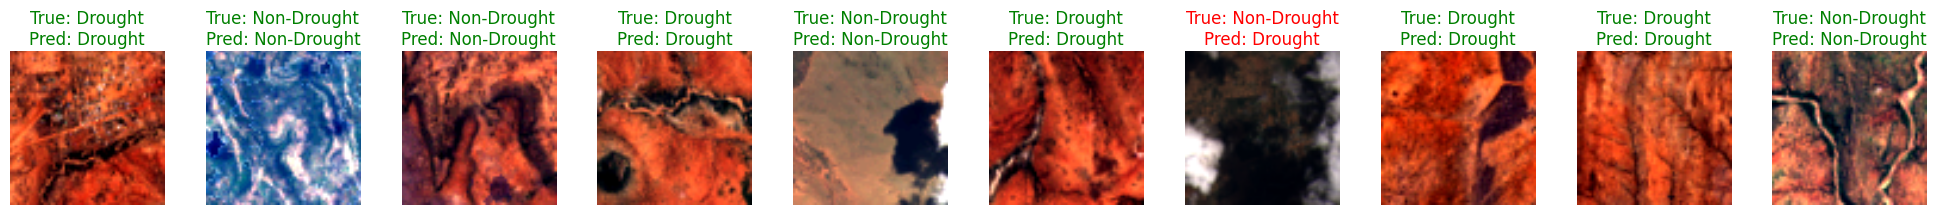

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from skimage import exposure

def enhance_image_gentle(img):
    """
    Gently enhances image quality while maintaining natural appearance.
    """
    # Convert to float32 and ensure 0-1 range
    img = img.astype(np.float32)
    if img.max() > 1:
        img = img / 255.0

    # Gentle contrast enhancement
    p2, p98 = np.percentile(img, (2, 98))
    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

    # Very slight gamma adjustment
    img_enhanced = exposure.adjust_gamma(img_rescale, 1.1)

    return img_enhanced

def visualize_predictions(model, dataset, num_images=10):
    """
    Visualizes images with their true and predicted labels.
    """
    plt.figure(figsize=(20, 6))  # Made taller for better visibility

    for images, labels in dataset.take(1):
        predictions = model.predict(images)
        predictions = (predictions >= 0.5).astype(int)

        for i in range(min(num_images, len(images))):
            plt.subplot(1, num_images, i + 1)

            # Enhance image
            img = images[i].numpy()
            enhanced_img = enhance_image_gentle(img)

            # Display with better interpolation
            plt.imshow(enhanced_img, interpolation='bilinear')

            # Labels
            true_label = "Drought" if labels[i] == 0 else "Non-Drought"
            pred_label = "Drought" if predictions[i] == 0 else "Non-Drought"
            color = 'green' if labels[i] == predictions[i] else 'red'

            plt.title(f'True: {true_label}\nPred: {pred_label}',
                     color=color,
                     pad=5)
            plt.axis('off')

        plt.tight_layout(pad=3.0)
        plt.show()

# Visualize predictions
print("Visualizing predictions on validation dataset:")
visualize_predictions(model, final_val_dataset.unbatch().batch(32))

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from skimage import exposure

def enhance_image_gentle(img):
    """
    Gently enhances image quality while maintaining natural appearance.
    """
    # Convert to float32 and ensure 0-1 range
    img = img.astype(np.float32)
    if img.max() > 1:
        img = img / 255.0

    # Apply CLAHE to reduce excessive brightness and improve contrast
    img_eq = exposure.equalize_adapthist(img, clip_limit=0.03)

    # Gentle contrast enhancement
    p2, p98 = np.percentile(img_eq, (2, 98))
    img_rescale = exposure.rescale_intensity(img_eq, in_range=(p2, p98))

    # Very slight gamma adjustment
    img_enhanced = exposure.adjust_gamma(img_rescale, 1.05)

    return img_enhanced

def visualize_predictions(model, dataset, num_images=64):
    """
    Visualizes images with their true and predicted labels.
    """
    plt.figure(figsize=(50, 30))  # Significantly increased figure size

    for images, labels in dataset.shuffle(10).take(1):  # Shuffle to avoid blank images
        predictions = model.predict(images)
        predictions = (predictions >= 0.5).astype(int)

        grid_size = int(np.ceil(np.sqrt(num_images)))  # Adjusting grid dynamically

        for i in range(min(num_images, len(images))):
            plt.subplot(grid_size, grid_size, i + 1)

            # Enhance image
            img = images[i].numpy()
            enhanced_img = enhance_image_gentle(img)

            # Display with better interpolation
            plt.imshow(enhanced_img, interpolation='bilinear')

            # Labels
            true_label = "Drought" if labels[i] == 0 else "Non-Drought"
            pred_label = "Drought" if predictions[i] == 0 else "Non-Drought"
            color = 'green' if labels[i] == predictions[i] else 'red'

            plt.title(f'True: {true_label}\nPred: {pred_label}',
                      color=color,
                      fontsize=16,
                      pad=10)
            plt.axis('off')

        plt.tight_layout(pad=5.0)
        plt.show()

# Visualize predictions
print("Visualizing predictions on validation dataset:")
visualize_predictions(model, final_val_dataset.unbatch().batch(32))


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from skimage import exposure

def enhance_image_gentle(img):
    """
    Gently enhances image quality while maintaining natural appearance.
    """
    # Convert to float32 and ensure 0-1 range
    img = img.astype(np.float32)
    if img.max() > 1:
        img = img / 255.0

    # Apply CLAHE to reduce excessive brightness and improve contrast
    img_eq = exposure.equalize_adapthist(img, clip_limit=0.03)

    # Gentle contrast enhancement
    p2, p98 = np.percentile(img_eq, (2, 98))
    img_rescale = exposure.rescale_intensity(img_eq, in_range=(p2, p98))

    # Very slight gamma adjustment
    img_enhanced = exposure.adjust_gamma(img_rescale, 1.05)

    return img_enhanced

def visualize_predictions(model, dataset, num_images=64):
    """
    Visualizes images with their true and predicted labels.
    """
    plt.figure(figsize=(50, 30))  # Significantly increased figure size

    for images, labels in dataset.shuffle(10).take(1):  # Shuffle to avoid blank images
        predictions = model.predict(images)
        predictions = (predictions >= 0.5).astype(int)

        grid_size = int(np.ceil(np.sqrt(num_images)))  # Adjusting grid dynamically

        for i in range(min(num_images, len(images))):
            plt.subplot(grid_size, grid_size, i + 1)

            # Enhance image
            img = images[i].numpy()
            enhanced_img = enhance_image_gentle(img)

            # Display with better interpolation
            plt.imshow(enhanced_img, interpolation='bilinear')

            # Labels
            true_label = "Drought" if labels[i] == 0 else "Non-Drought"
            pred_label = "Drought" if predictions[i] == 0 else "Non-Drought"
            color = 'green' if labels[i] == predictions[i] else 'red'

            plt.title(f'True: {true_label}\nPred: {pred_label}',
                      color=color,
                      fontsize=16,
                      pad=10)
            plt.axis('off')

        plt.tight_layout(pad=5.0)
        plt.show()

# Visualize predictions
print("Visualizing predictions on validation dataset:")
visualize_predictions(model, final_val_dataset.unbatch().batch(32))


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from skimage import exposure

def enhance_image_gentle(img):
    """
    Gently enhances image quality while maintaining natural appearance.
    """
    # Convert to float32 and ensure 0-1 range
    img = img.astype(np.float32)
    if img.max() > 1:
        img = img / 255.0

    # Apply CLAHE to reduce excessive brightness and improve contrast
    img_eq = exposure.equalize_adapthist(img, clip_limit=0.03)

    # Gentle contrast enhancement
    p2, p98 = np.percentile(img_eq, (2, 98))
    img_rescale = exposure.rescale_intensity(img_eq, in_range=(p2, p98))

    # Very slight gamma adjustment
    img_enhanced = exposure.adjust_gamma(img_rescale, 1.05)

    return img_enhanced

def visualize_predictions(model, dataset, num_images=64):
    """
    Visualizes images with their true and predicted labels.
    """
    plt.figure(figsize=(50, 30))  # Significantly increased figure size

    for images, labels in dataset.shuffle(10).take(1):  # Shuffle to avoid blank images
        predictions = model.predict(images)
        predictions = (predictions >= 0.5).astype(int)

        grid_size = int(np.ceil(np.sqrt(num_images)))  # Adjusting grid dynamically

        for i in range(min(num_images, len(images))):
            plt.subplot(grid_size, grid_size, i + 1)

            # Enhance image
            img = images[i].numpy()
            enhanced_img = enhance_image_gentle(img)

            # Display with better interpolation
            plt.imshow(enhanced_img, interpolation='bilinear')

            # Labels
            true_label = "Drought" if labels[i] == 0 else "Non-Drought"
            pred_label = "Drought" if predictions[i] == 0 else "Non-Drought"
            color = 'green' if labels[i] == predictions[i] else 'red'

            plt.title(f'True: {true_label}\nPred: {pred_label}',
                      color=color,
                      fontsize=16,
                      pad=10)
            plt.axis('off')

        plt.tight_layout(pad=5.0)
        plt.show()

# Visualize predictions
print("Visualizing predictions on validation dataset:")
visualize_predictions(model, final_val_dataset.unbatch().batch(32))


Output hidden; open in https://colab.research.google.com to view.

In [ ]:

def predict_single_image(model, image_path):
    """
    Predicts drought condition for a single image.

    Args:
        model: trained tensorflow model
        image_path: path to the image file
    """
    # Read and preprocess image
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(65, 65))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Add batch dimension

    # Make prediction
    prediction = model.predict(img_array)
    pred_label = "Drought" if prediction[0][0] < 0.5 else "Non-Drought"
    confidence = prediction[0][0] if prediction[0][0] >= 0.5 else 1 - prediction[0][0]

    # Display image with prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f'Prediction: {pred_label}\nConfidence: {confidence:.2%}',
             color='blue', pad=10)
    plt.axis('off')
    plt.show()

In [ ]:
# Replace with your image path
image_path = '/content/AnnualCrop_6.jpg'
predict_single_image(model, image_path)

FileNotFoundError: [Errno 2] No such file or directory: '/content/AnnualCrop_6.jpg'

In [ ]:
# Replace with your image path
image_path = '/content/AnnualCrop_9.jpg'
predict_single_image(model, image_path)

In [ ]:
# Replace with your image path
image_path = '/content/AnnualCrop_18.jpg'
predict_single_image(model, image_path)

In [ ]:
# Replace with your image path
image_path = '/content/18 - Copy.jpg'
predict_single_image(model, image_path)

In [ ]:
# Replace with your image path
image_path = '/content/nodr1.png'
predict_single_image(model, image_path)

In [ ]:
# Replace with your image path
image_path = '/content/10.png'
predict_single_image(model, image_path)

In [ ]:
# Replace with your image path
image_path = '/content/drought3.png'
predict_single_image(model, image_path)

In [ ]:
# Replace with your image path
image_path = '/content/drought2.jpg'
predict_single_image(model, image_path)

In [ ]:
# Replace with your image path
image_path = '/content/drought4.png'
predict_single_image(model, image_path)

In [ ]:
# Replace with your image path
image_path = '/content/drought5.png'
predict_single_image(model, image_path)

In [ ]:
# Replace with your image path
image_path = '/content/drought6.png'
predict_single_image(model, image_path)

In [ ]:
# Replace with your image path
image_path = '/content/20.jpg'
predict_single_image(model, image_path)

In [ ]:
# Replace with your image path
image_path = '/content/7.jpg'
predict_single_image(model, image_path)

In [ ]:
# Replace with your image path
image_path = '/content/Industrial_10.jpg'
predict_single_image(model, image_path)

In [ ]:
# Replace with your image path
image_path = '/content/Industrial_4.jpg'
predict_single_image(model, image_path)

In [ ]:
# Replace with your image path
image_path = '/content/Screenshot 2025-02-04 134654.png'
predict_single_image(model, image_path)

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

def predict_single_image(model, image_path):
    """
    Predicts drought condition for a single image.

    Args:
        model: trained tensorflow model
        image_path: path to the image file
    """
    # Read and resize the image to the model's expected input size (e.g., 65x65)
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(65, 65))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Add batch dimension

    # Make prediction
    prediction = model.predict(img_array)
    pred_label = "Drought" if prediction[0][0] < 0.5 else "Non-Drought"
    confidence = prediction[0][0] if prediction[0][0] >= 0.5 else 1 - prediction[0][0]

    # Display the original image without resizing for clarity
    original_img = tf.keras.preprocessing.image.load_img(image_path)

    plt.figure(figsize=(6, 6))
    plt.imshow(original_img)
    plt.title(f'Prediction: {pred_label}\nConfidence: {confidence:.2%}',
             color='blue', pad=10)
    plt.axis('off')
    plt.show()


In [ ]:
# Replace with your image path
image_path = '/content/Screenshot 2025-02-04 134654.png'
predict_single_image(model, image_path)

In [ ]:
# Replace with your image path
image_path = '/content/drought3.png'
predict_single_image(model, image_path)